# A Blending Problem - Revisited with PuLP and Pandas

PuLP is an outsanding library for optimization. However, most of the example use cases you will find on the web are somewhat outdated.  
In this notebook, we introduce a more intuitive and convenient way of using PuLP package in combination with Pandas.

For detailed problem description and original solution provided by *Anthony Pillips* and *Dr Stuart Mitchell*, please see the notebook `A Blending Problem - Introduction to Optimization.ipynb`, or the original website: https://pythonhosted.org/PuLP/.

In [1]:
"""
The Full Whiskas Model Pandas/Python Formulation for the PuLP Modeller

Authors: Cesar 2019
"""

from pulp import LpProblem, LpMinimize, LpVariable, value
import pandas as pd

## Brief Description

Whiskas cat food, shown above, is manufactured by Uncle Ben’s. Uncle Ben’s want to produce their cat food products as cheaply as possible while ensuring they meet the stated nutritional analysis requirements shown on the cans. Thus they want to vary the quantities of each ingredient used (the main ingredients being chicken, beef, mutton, rice, wheat and gel) while still meeting their nutritional standards.

The costs of the chicken, beef, and mutton are \\$0.013, \\$0.008 and \\$0.010 respectively, while the costs of the rice, wheat and gel are \\$0.002, \\$0.005 and \\$0.001 respectively. (All costs are per gram.) For this exercise we will ignore the vitamin and mineral ingredients. (Any costs for these are likely to be very small anyway.)


Each ingredient contributes to the total weight of protein, fat, fibre and salt in the final product. The contributions (in grams) per gram of ingredient are given in the table below.

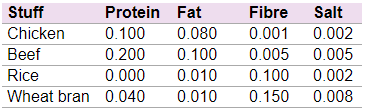

Nutritional values are given below in seperate dictionaries:

In [2]:
# A dictionary of the costs of each of the Ingredients is created
costs = {'CHICKEN': 0.013, 'BEEF': 0.008, 
         'MUTTON': 0.010, 'RICE': 0.002, 
         'WHEAT': 0.005, 'GEL': 0.001}

# A dictionary of the protein percent in each of the Ingredients is created
proteinPercent = {'CHICKEN': 0.100, 'BEEF': 0.200, 
                  'MUTTON': 0.150, 'RICE': 0.000, 
                  'WHEAT': 0.040, 'GEL': 0.000}

# A dictionary of the fat percent in each of the Ingredients is created
fatPercent = {'CHICKEN': 0.080, 'BEEF': 0.100, 
              'MUTTON': 0.110, 'RICE': 0.010, 
              'WHEAT': 0.010, 'GEL': 0.000}

# A dictionary of the fibre percent in each of the Ingredients is created
fibrePercent = {'CHICKEN': 0.001, 'BEEF': 0.005, 
                'MUTTON': 0.003, 'RICE': 0.100, 
                'WHEAT': 0.150, 'GEL': 0.000}

# A dictionary of the salt percent in each of the Ingredients is created
saltPercent = {'CHICKEN': 0.002, 'BEEF': 0.005, 
               'MUTTON': 0.007, 'RICE': 0.002, 
               'WHEAT': 0.008, 'GEL': 0.000}

Using dictionaries defined above, nutritional values are converted into a pandas DataFrame.

In [3]:
data = pd.DataFrame({'costs':costs,
                     'proteinPercent': proteinPercent,
                     'fatPercent': fatPercent,
                     'fibrePercent': fibrePercent,
                     'saltPercent': saltPercent})
data

,costs,proteinPercent,fatPercent,fibrePercent,saltPercent
BEEF,0.008,0.20,0.10,0.005,0.005
CHICKEN,0.013,0.10,0.08,0.001,0.002
GEL,0.001,0.00,0.00,0.000,0.000
MUTTON,0.010,0.15,0.11,0.003,0.007
RICE,0.002,0.00,0.01,0.100,0.002
WHEAT,0.005,0.04,0.01,0.150,0.008


At this point, variables are created as ingredient precentages for each item.

Since items simply cannot have negative ingredient percentage, we define upper and lower boundaries of percentages as `0` and `100`, respectively.

In [4]:
variables = [LpVariable(f"{ingredient}_pct",0,100) for ingredient in data.index]
data['ingredient_pct'] = variables
data

,costs,proteinPercent,fatPercent,fibrePercent,saltPercent,ingredient_pct
BEEF,0.008,0.20,0.10,0.005,0.005,BEEF_pct
CHICKEN,0.013,0.10,0.08,0.001,0.002,CHICKEN_pct
GEL,0.001,0.00,0.00,0.000,0.000,GEL_pct
MUTTON,0.010,0.15,0.11,0.003,0.007,MUTTON_pct
RICE,0.002,0.00,0.01,0.100,0.002,RICE_pct
WHEAT,0.005,0.04,0.01,0.150,0.008,WHEAT_pct


Problem object is initiated.

In [5]:
prob = LpProblem('WhiskasOpt', LpMinimize)

Optimization objective for this problem is, intuitively, minimizing the cost while keeping the nutritional standard of the food.  
Total cost can be defined as
$$ total\ cost= \sum_i{(cost_i\ percentage_i\ can\ size)}$$
$$where\ i\ \in food\ items$$

In [6]:
# optimization objective:

prob += (data['costs'] * data['ingredient_pct']).sum()

Nutritional standards for each can is as follows:
- Each 100 g can must contain:
    - At least 8 grams of protein,
    - At least 6 grams of fat,
    - At most 2 grams of fibre, and
    - At most 2 grams of salt

In [7]:
# Constraints:

# Percentages add up to 100
prob += data['ingredient_pct'].sum() == 100

# Protein Ingredient
prob += (data['ingredient_pct'] * data['proteinPercent']).sum() >= 8.0, "ProteinReq"

# Fat Ingredient
prob += (data['ingredient_pct'] * data['fatPercent']).sum() >= 6.0, "FatReq"

# Fibre Ingredient
prob += (data['ingredient_pct'] * data['fibrePercent']).sum() <= 2.0, "FibreReq"

# Salt ingredient
prob += (data['ingredient_pct'] * data['saltPercent']).sum() <= 2.0, "SaltReq"


This file is very useful to check your optimization objective and constraints.  
It is highly recommended that you give significant names to your constraints so you can easily identify them later if any debugging necessity arises.

In [8]:
prob.writeLP("../LP-Files/WhiskasPd.lp")

In [9]:
prob.solve()

1

In [10]:
print(f"Optimal cost of each 100g food can: ${prob.objective.value()}")

Optimal cost of each 100g food can: $0.52


Finally, we can inspect the optimal food item percentages as follows:

In [11]:
data['ingredient_pct'].apply(lambda x: x.value())

BEEF       60.0
CHICKEN     0.0
GEL        40.0
MUTTON      0.0
RICE        0.0
WHEAT       0.0
Name: ingredient_pct, dtype: float64